In [1]:
from scipy.io import arff
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from pyts.classification import BOSSVS
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import cohen_kappa_score, confusion_matrix, roc_auc_score, accuracy_score, f1_score, RocCurveDisplay, roc_curve, auc, ConfusionMatrixDisplay, classification_report

In [2]:
leafNames = ["Ulmus carpinifolia", "Acer", "Salix aurita", "Quercus", "Alnus incana",
             "Betula pubescens", "Salix alba 'Sericea'", "Populus tremula", "Ulmus glabra",
             "Sorbus aucuparia", "Salix sinerea", "Populus", "Tilia", "Sorbus intermedia", "Fagus silvatica"]

In [3]:
train_data, train_meta = arff.loadarff("SwedishLeaf/SwedishLeaf_Train.arff") 
test_data, test_meta = arff.loadarff("SwedishLeaf/SwedishLeaf_Test.arff")

train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

In [4]:
# splitting Xtrain, ytrain, Xtest, ytest, Xval, yval from data
"""Had to minus one off of the y data because to fit in the cnn model it needs the amount of classes
this being said it counts from zero so having a class with the value of 15 is out of range."""
# Xtrain, ytrain, Xtest, ytest, Xval, yval = [], [], [], [], [], []
# for i in range(len(train_df)):
#     Xtrain.append(train_df.iloc[i][0:128])
#     ytrain.append(int(str(train_df.iloc[i][-1]).strip("b").replace("'", "")) - 1) 
    
# for i in range(len(test_df)):
#     Xtest.append(test_df.iloc[i][0:128])
#     ytest.append(int(str(test_df.iloc[i][-1]).strip("b").replace("'", "")) - 1) 

'Had to minus one off of the y data because to fit in the cnn model it needs the amount of classes\nthis being said it counts from zero so having a class with the value of 15 is out of range.'

In [20]:
# Xdata, ydata = [], []
# for i in range(len(train_df)):
#     Xdata.append(train_df.iloc[i][0:128])
#     ydata.append(int(str(train_df.iloc[i][-1]).strip("b").replace("'", "")) - 1) 
    
# for i in range(len(test_df)):
#     Xdata.append(test_df.iloc[i][0:128])
#     ydata.append(int(str(test_df.iloc[i][-1]).strip("b").replace("'", "")) - 1) 
  

# Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, ydata, test_size=0.3, random_state=123)

In [31]:
Xdata, ydata = [], []
for i in range(len(train_df)):
    Xdata.append(train_df.iloc[i][0:128])
    ydata.append(int(str(train_df.iloc[i][-1]).strip("b").replace("'", "")) - 1) 
    
for i in range(len(test_df)):
    Xdata.append(test_df.iloc[i][0:128])
    ydata.append(int(str(test_df.iloc[i][-1]).strip("b").replace("'", "")) - 1) 
  
# get a balenced number of each class in training and testing 
ten_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)

Xdata = np.array(Xdata)
ydata = np.array(ydata)

for train_index, test_index in ten_fold.split(Xdata, ydata):
    Xtrain, Xtest = Xdata[train_index], Xdata[test_index]
    ytrain, ytest = ydata[train_index], ydata[test_index]

In [32]:
#found the highest accuracy though the commented out code
accs = []
f1s = []
cks = []
ra = []
classes_of_classifier = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
for i in range(2, 15):
# scores started getting worse after word_size of 7

    bag_of_sfa_vs = BOSSVS(word_size=i,n_bins=i,window_size=16)
    bag_of_sfa_vs.fit(Xtrain, ytrain)

#     tf_idf = bag_of_sfa_vs.tfidf_
    cos_sim_bag_of_sfa_vs_ypred = bag_of_sfa_vs.decision_function(Xtest)

    bag_of_sfa_vs_ypred = bag_of_sfa_vs.predict(Xtest)
    
    
    accs.append(accuracy_score(ytest, bag_of_sfa_vs_ypred))
    cks.append(cohen_kappa_score(ytest, bag_of_sfa_vs_ypred))
    
    lb = LabelBinarizer()
    lb.fit(ytest)
    ytest_temp = lb.transform(ytest)
    bag_of_sfa_vs_ypred = lb.transform(bag_of_sfa_vs_ypred)
    
    f1s.append(f1_score(ytest_temp, bag_of_sfa_vs_ypred, labels=classes_of_classifier, average='weighted'))
    ra.append(roc_auc_score(ytest_temp, bag_of_sfa_vs_ypred, average="weighted", multi_class="ovr"))
    
      
print(accs)    
print(f1s)
print(cks)
print(ra)

[0.21428571428571427, 0.2767857142857143, 0.5267857142857143, 0.6696428571428571, 0.8035714285714286, 0.8571428571428571, 0.8571428571428571, 0.7767857142857143, 0.7767857142857143, 0.6875, 0.6428571428571429, 0.6160714285714286, 0.5803571428571429]
[0.13332466960184353, 0.2224504350568592, 0.5162003472717759, 0.6559666411157552, 0.7969246031746032, 0.8574655490186505, 0.8609590310483168, 0.7615720807553791, 0.7634841853408031, 0.6622079921712275, 0.5976900464516565, 0.5708097636461144, 0.5345496617492643]
[0.15767883086915646, 0.22468165114092808, 0.4939039986358599, 0.6464163822525597, 0.789491670226399, 0.8469161113958654, 0.8469422617014007, 0.7607451080919422, 0.7607859888936352, 0.6651289936784555, 0.6173883337603553, 0.5883408838362253, 0.5501239210323904]
[0.5788003663003662, 0.612408424908425, 0.7474358974358976, 0.8235347985347986, 0.8948260073260075, 0.9234890109890109, 0.9235347985347987, 0.8803113553113554, 0.8803571428571431, 0.832371794871795, 0.8085622710622712, 0.79395

In [33]:
overall_highest_avg = [0,0]
for i in range(len(accs)):
    avg = (accs[i] + f1s[i] + cks[i] + ra[i]) / 4
    if avg > overall_highest_avg[1]:
        overall_highest_avg[1] = avg
        overall_highest_avg[0] = i
print(overall_highest_avg)

[6, 0.8721447371068434]


In [41]:
print("BOSSVS highest average")
print(f"average of all scores {overall_highest_avg[1]} and index: {overall_highest_avg[0]}\n"
    f"hyper parameters: [6, 6]\n"
     f"accuracy score: {accs[overall_highest_avg[0]]}\n"
     f"auc score:  {ra[overall_highest_avg[0]]}\n"
     f"cohen kappa score:  {cks[overall_highest_avg[0]]}\n"
     f"f1 score:  {f1s[overall_highest_avg[0]]}\n")

BOSSVS highest average
average of all scores 0.8721447371068434 and index: 6
hyper parameters: [6, 6]
accuracy score: 0.8571428571428571
auc score:  0.9235347985347987
cohen kappa score:  0.8469422617014007
f1 score:  0.8609590310483168



In [9]:
classes_of_classifier = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

In [4]:
# cohen kappa score
def get_cohen_kappa_score(ytest, ypred):
    return cohen_kappa_score(ytest, ypred)

In [5]:
def get_roc_auc_score(ytest_transform, ypred_transform):
    return roc_auc_score(ytest_transform, ypred_transform, average="weighted", multi_class="ovr")

In [6]:
def get_accuracy_score(ytest, ypred):
    return accuracy_score(ytest, ypred)

In [7]:
def get_f1_score(ytest_transform, ypred_transform):
    return f1_score(ytest_transform, ypred_transform, labels=classes_of_classifier, average="weighted")

In [16]:
def get_avg(l):
    return sum(l)/len(l)

In [34]:
Xdata, ydata = [], []
for i in range(len(train_df)):
    Xdata.append(train_df.iloc[i][0:128])
    ydata.append(int(str(train_df.iloc[i][-1]).strip("b").replace("'", "")) - 1) 
    
for i in range(len(test_df)):
    Xdata.append(test_df.iloc[i][0:128])
    ydata.append(int(str(test_df.iloc[i][-1]).strip("b").replace("'", "")) - 1) 
  
# get a balenced number of each class in training and testing 
ten_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)

Xdata = np.array(Xdata)
ydata = np.array(ydata)

overall_ytest, overall_ypred = [], []

ten_fold_bossvs_accuracy, ten_fold_bossvs_cohen_kappa, ten_fold_bossvs_roc_auc, ten_fold_bossvs_f1 = [], [], [], []

for train_index, test_index in ten_fold.split(Xdata, ydata):
    Xtrain, Xtest = Xdata[train_index], Xdata[test_index]
    ytrain, ytest = ydata[train_index], ydata[test_index]
    
    overall_ytest.extend(ytest)
    
    bag_of_sfa_vs = BOSSVS(word_size=6,n_bins=6,window_size=16)
    bag_of_sfa_vs.fit(Xtrain, ytrain)

    cos_sim_bag_of_sfa_vs_ypred = bag_of_sfa_vs.decision_function(Xtest)
    bag_of_sfa_vs_ypred = bag_of_sfa_vs.predict(Xtest)
    overall_ypred.extend(bag_of_sfa_vs_ypred)
    
    ten_fold_bossvs_accuracy.append(get_accuracy_score(ytest, bag_of_sfa_vs_ypred))
    ten_fold_bossvs_cohen_kappa.append(get_cohen_kappa_score(ytest, bag_of_sfa_vs_ypred))
    
    # Transform multi-class labels to binary labels
    lb = LabelBinarizer()
    lb.fit(ytest)
    ytest = lb.transform(ytest)
    bag_of_sfa_vs_ypred = lb.transform(bag_of_sfa_vs_ypred)
    
    ten_fold_bossvs_roc_auc.append(get_roc_auc_score(ytest, bag_of_sfa_vs_ypred))
    ten_fold_bossvs_f1.append(get_f1_score(ytest, bag_of_sfa_vs_ypred))

In [43]:
print(f"BOSSVS average accuracy: {get_avg(ten_fold_bossvs_accuracy)} \n BOSSVS average cohen kappa {get_avg(ten_fold_bossvs_cohen_kappa)} \n BOSSVS average roc_auc {get_avg(ten_fold_bossvs_roc_auc)} \n BOSSVS average f1 {get_avg(ten_fold_bossvs_f1)}")

BOSSVS average accuracy: 0.7751106194690266 
 BOSSVS average cohen kappa 0.7589909537125467 
 BOSSVS average roc_auc 0.8794894256686708 
 BOSSVS average f1 0.7633994125587616


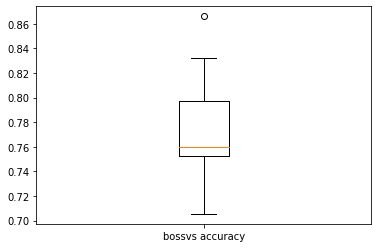

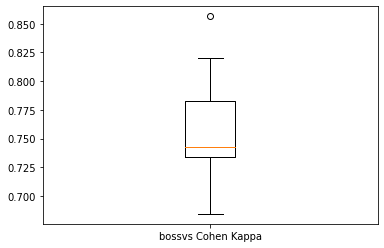

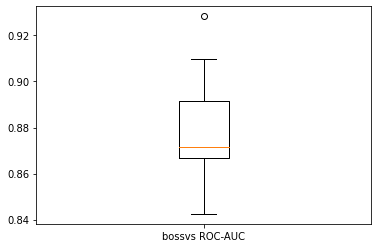

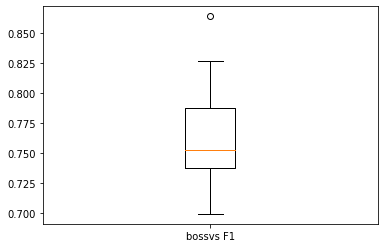

In [45]:
label1 = ["bossvs accuracy"]
label2 = ["bossvs Cohen Kappa"]
label3 = ["bossvs ROC-AUC"]
label4 = ["bossvs F1"]
box_plot_accuracy_data = [ten_fold_bossvs_accuracy]
box_plot_cohen_kappa_data = [ten_fold_bossvs_cohen_kappa]
box_plot_roc_auc_data = [ten_fold_bossvs_roc_auc]
box_plot_f1_score_data = [ten_fold_bossvs_f1]

plt.boxplot(box_plot_accuracy_data, labels=label1)
plt.show()

plt.boxplot(box_plot_cohen_kappa_data, labels=label2)
plt.show()

plt.boxplot(box_plot_roc_auc_data, labels=label3)
plt.show()

plt.boxplot(box_plot_f1_score_data, labels=label4)
plt.show()

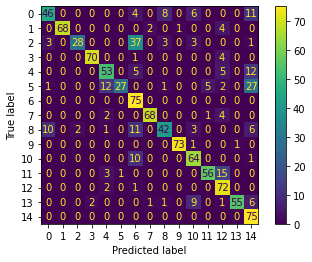

In [37]:
# displaying confustion matrix
cm = confusion_matrix(overall_ytest, overall_ypred, labels=classes_of_classifier)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_of_classifier)
disp.plot()
plt.show() 

In [38]:
def roc_auc_score_and_graph(ytest, ypred):
    
    # Transform multi-class labels to binary labels
    lb = LabelBinarizer()
    lb.fit(ytest)
    ytest = lb.transform(ytest)
    ypred = lb.transform(ypred)
    
    plt.figure(figsize = (12, 8))

    for (i, label) in enumerate(leafNames):
        fpr, tpr, thresholds = roc_curve(ytest[:,i], ypred[:,i])
        plt.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))

    print(roc_auc_score(ytest, ypred, average="weighted", multi_class="ovr"))
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

0.8795238095238097


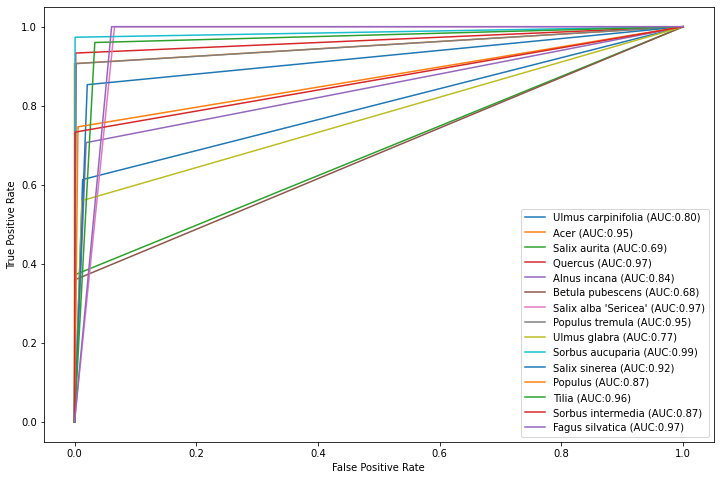

In [39]:
roc_auc_score_and_graph(overall_ytest, overall_ypred)